This kernal is an attempt to learn and practice PyTorch. Referred https://github.com/udacity/deep-learning-v2-pytorch/tree/master/intro-to-pytorch

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test1', 'sampleSubmission.csv', 'train']


In [2]:
total = 0
for root, dirs, files in os.walk("../input/train/train/"):
    total += len(files)
print(total)

25000


### Setting up Data
Going to load image data with `datasets.ImageFolder` from `torchvision`.
ImageFolder expects the files and directories to be constructed like so:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. 

Create a new directory `train` and move all of the training data there.

In [3]:
!cp -r ../input/train/train ./train

In [4]:
print(os.listdir("."))

['train', '.ipynb_checkpoints', '__notebook_source__.ipynb']


Make 2 new directories with names matching the labels for classification.

In [5]:
!mkdir ./train/cat
!mkdir ./train/dog

Move dog images to `dog` folder. And cat images to `cat` folder.

In [6]:
import re, shutil
from os import listdir
from tqdm import tqdm_notebook
train1 = []
for i in tqdm_notebook(listdir('../input/train/train/')):
    if re.search("cat", i):
        shutil.move('./train/'+i, './train/cat/')
    else:
        shutil.move('./train/'+i, './train/dog/')

In [7]:
total = 0
for root, dirs, files in os.walk("./train/dog/"):
    total += len(files)
for root, dirs, files in os.walk("./train/cat/"):
    total += len(files)   
print(total)

25000


Import necessary packages

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Custom function to display image

In [9]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Load Train, Validation and Test data

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('./train', transform=train_transforms)
test_data = datasets.ImageFolder('../input/test1', transform=test_transforms)

# Creating data indices for training and validation splits:
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(train_data)
print(f'Total train_data size = {dataset_size}')
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler)

print(f'trainloader size = {len(trainloader)}')
print(f'validloader size = {len(validloader)}')
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Total train_data size = 25000
trainloader size = 625
validloader size = 157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


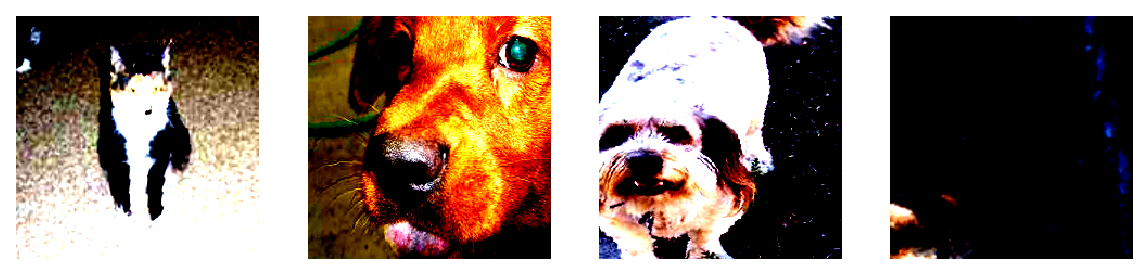

In [11]:
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

Classifier Model 

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(150528, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x


In [13]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Training and inference

In [15]:
epochs = 10

train_losses, test_losses = [], []
#for e in range(epochs):
for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    running_loss = 0
    for images, labels in trainloader:
        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(validloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))

Epoch: 1/10..  Training Loss: 1.187..  Test Loss: 0.699..  Test Accuracy: 0.509
Epoch: 2/10..  Training Loss: 0.714..  Test Loss: 0.684..  Test Accuracy: 0.556
Epoch: 3/10..  Training Loss: 0.710..  Test Loss: 0.699..  Test Accuracy: 0.532
Epoch: 4/10..  Training Loss: 0.720..  Test Loss: 0.691..  Test Accuracy: 0.529
Epoch: 5/10..  Training Loss: 0.707..  Test Loss: 0.693..  Test Accuracy: 0.498
Epoch: 6/10..  Training Loss: 0.697..  Test Loss: 0.694..  Test Accuracy: 0.496
Epoch: 7/10..  Training Loss: 0.694..  Test Loss: 0.693..  Test Accuracy: 0.498
Epoch: 8/10..  Training Loss: 0.695..  Test Loss: 0.693..  Test Accuracy: 0.502
Epoch: 9/10..  Training Loss: 0.697..  Test Loss: 0.693..  Test Accuracy: 0.503
Epoch: 10/10..  Training Loss: 0.694..  Test Loss: 0.694..  Test Accuracy: 0.503



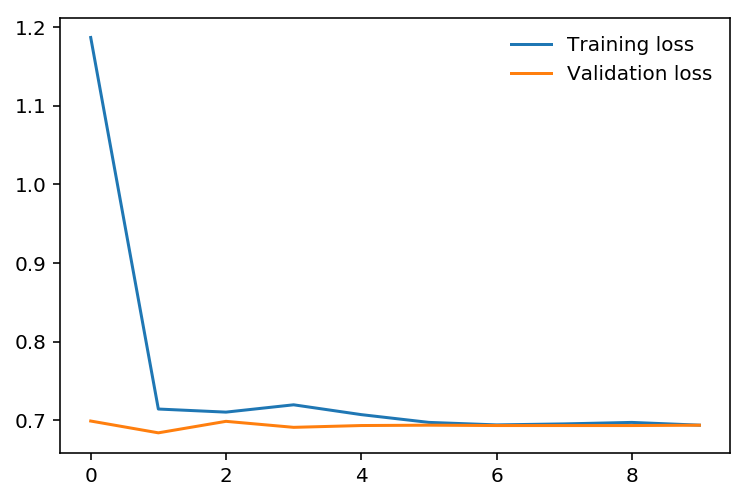

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Transfer Learning approach

With `torchvision.models` you can download these pre-trained networks and use them in your applications. 
Loading in a DenseNet model.

In [17]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/.torch/models/densenet121-a639ec97.pth
32342954it [00:00, 114909111.44it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [18]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

Training and Inference

In [19]:
epochs = 5
train_losses, test_losses = [], []
for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    running_loss = 0
    for images, labels in trainloader:
        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss.item()

                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))
        model.train()


Epoch: 1/5..  Training Loss: 0.201..  Test Loss: 0.130..  Test Accuracy: 0.940
Epoch: 2/5..  Training Loss: 0.178..  Test Loss: 0.133..  Test Accuracy: 0.940
Epoch: 3/5..  Training Loss: 0.161..  Test Loss: 0.122..  Test Accuracy: 0.950
Epoch: 4/5..  Training Loss: 0.165..  Test Loss: 0.137..  Test Accuracy: 0.944
Epoch: 5/5..  Training Loss: 0.151..  Test Loss: 0.129..  Test Accuracy: 0.942



In [20]:
sub_label = []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        sub_label.extend(top_class.view(-1).tolist())
        #print(top_class.view(-1).tolist())

In [21]:
sub_id = [x for x in range(1,len(sub_label)+1)]

In [22]:
submission = pd.DataFrame({'id':sub_id, 'label':sub_label})
submission = submission[['id', 'label']]
submission.head()


,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1


In [23]:
submission.to_csv("submission.csv", index=False)